## 7.1 深度卷积神经网络 AlexNet

### 7.1.2 AlexNet

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
net = nn.Sequential(
    # 用更大的窗口捕捉对象。同时stride=4减少输出的高度和宽度。输出通道数目远大于LeNet
    # 有96个卷积核，每个卷积核的大小为11*11
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减少卷积窗口，用填充为2让输入输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 3个卷积层和较小的卷积窗口，输出通道进一步增加
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 全连接层是LeNet的好几倍，用dropout层减少过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(0.5),
    # 输出层
    nn.Linear(4096, 10),
)

In [4]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

### 7.1.3 读取数据集

In [5]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

### 7.1.4 训练AlexNet

loss 0.327, train acc 0.879, test acc 0.885
4358.0 examples/sec on cuda:0


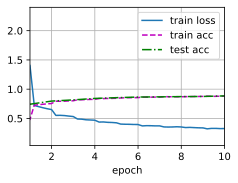

In [6]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 练习

GTX1050 就恕不奉陪了。。。有好设备了再说吧。。。

1. 试着增加迭代轮数。对比LeNet的结果有什么不同？为什么？

2. AlexNet对Fashion-MNIST数据集来说可能太复杂了。
    1. 尝试简化模型以加快训练速度，同时确保准确性不会显著下降。
    2. 设计一个更好的模型，可以直接在28x28图像上工作。

3. 修改批量大小，并观察模型精度和GPU显存变化。

4. 分析了AlexNet的计算性能。
    1. 在AlexNet中主要是哪部分占用显存？
    2. 在AlexNet中主要是哪部分需要更多的计算？
    3. 计算结果时显存带宽如何？

5. 将dropout和ReLU应用于LeNet-5，效果有提升吗？再试试预处理会怎么样？

## 7.2 VGG

### 7.2.1 VGG块

In [7]:
import torch
from torch import nn
from d2l import torch as d2l

In [8]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

### 7.2.2 VGG网络

In [9]:
conv_arch =((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [10]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    
    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10)
    )

In [11]:
net = vgg(conv_arch=conv_arch)

In [12]:
X = torch.randn(1, 1, 224, 224)
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


### 7.2.3 训练模型

loss 0.181, train acc 0.933, test acc 0.914
2541.7 examples/sec on cuda:0


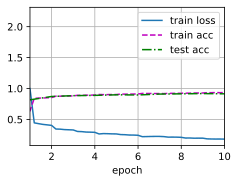

In [13]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]

net = vgg(small_conv_arch)

lr, num_epochs, batch_size = 0.05, 10, 128

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 练习

1. 打印层的尺寸时，我们只看到8个结果，而不是11个结果。剩余的3层信息去哪了？

2. 与AlexNet相比，VGG的计算要慢得多，而且它还需要更多的显存。分析出现这种情况的原因。

3. 尝试将Fashion-MNIST数据集图像的高度和宽度从224改为96。这对实验有什么影响？

4. 请参考VGG论文 (Simonyan and Zisserman, 2014)中的表1构建其他常见模型，如VGG-16或VGG-19。

## 7.3 网络中的网络 NiN

### 7.3.1 NiN块

In [14]:
import torch
from torch import nn
from d2l import torch as d2l

In [15]:
def nin_block(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU()
    )

### 7.3.2 NiN模型

In [16]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, stride=4, padding=0),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nin_block(96, 256, kernel_size=5, stride=1, padding=2),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nin_block(256, 384, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Dropout(0.5),
    # 标签类别是10
    nin_block(384, 10, kernel_size=3, stride=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
)

In [17]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Sequential output shape: 	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape: 	 torch.Size([1, 96, 26, 26])
Sequential output shape: 	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape: 	 torch.Size([1, 256, 12, 12])
Sequential output shape: 	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape: 	 torch.Size([1, 384, 5, 5])
Dropout output shape: 	 torch.Size([1, 384, 5, 5])
Sequential output shape: 	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape: 	 torch.Size([1, 10, 1, 1])
Flatten output shape: 	 torch.Size([1, 10])


### 7.3.3 训练模型

loss 0.565, train acc 0.782, test acc 0.805
4110.2 examples/sec on cuda:0


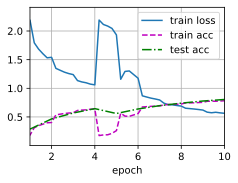

In [18]:
lr, num_epochs, batch_size = 0.1, 10, 128

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

1. 调整NiN的超参数，以提高分类准确性。

2. 为什么NiN块中有两个1x1卷积层？删除其中一个，然后观察和分析实验现象。

3. 计算NiN的资源使用情况。
    1. 参数的数量是多少？
    2. 计算量是多少？
    3. 训练期间需要多少显存？
    4. 预测期间需要多少显存？

4. 一次性直接将384x5x5的表示缩减为10x5x5的表示，会存在哪些问题

## 7.4 含有并行连结的网络 GoogLeNet

In [19]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

### 7.4.1 Inception块

In [20]:
class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
      super(Inception, self).__init__(**kwargs)
      # 线路1，单1x1卷积层
      self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
      # 线路2，1x1卷积层后接3x3卷积层
      self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
      self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
      # 线路3，1x1卷积层后接5x5卷积层
      self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
      self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
      # 线路4，3x3最大汇聚层后接1x1卷积层
      self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
      self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)
    
    def forward(self, x):
      p1 = F.relu(self.p1_1(x))
      p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
      p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
      p4 = F.relu(self.p4_2(self.p4_1(x)))
      # 在通道维度上连结输出
      return torch.cat((p1, p2, p3, p4), dim=1)

### 7.4.2 GoogLeNet模型

In [21]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [22]:
b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1), nn.ReLU(),
    nn.Conv2d(64, 192, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [23]:
b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [24]:
b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [25]:
b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
)

In [26]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [27]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Sequential output shape: 	 torch.Size([1, 64, 24, 24])
Sequential output shape: 	 torch.Size([1, 192, 12, 12])
Sequential output shape: 	 torch.Size([1, 480, 6, 6])
Sequential output shape: 	 torch.Size([1, 832, 3, 3])
Sequential output shape: 	 torch.Size([1, 1024])
Linear output shape: 	 torch.Size([1, 10])


### 7.4.3 训练模型

loss 0.256, train acc 0.902, test acc 0.856
4350.9 examples/sec on cuda:0


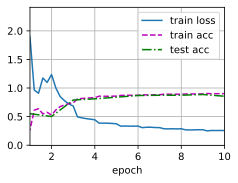

In [28]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

1. GoogLeNet有一些后续版本。尝试实现并运行它们，然后观察实验结果。这些后续版本包括：

    - 添加批量规范化层 (Ioffe and Szegedy, 2015)（batch normalization），在 7.5节中将介绍；
    - 对Inception模块进行调整 (Szegedy et al., 2016)；
    - 使用标签平滑（label smoothing）进行模型正则化 (Szegedy et al., 2016)；
    - 加入残差连接 (Szegedy et al., 2017)。（ 7.6节将介绍）。

2. 使用GoogLeNet的最小图像大小是多少？

3. 将AlexNet、VGG和NiN的模型参数大小与GoogLeNet进行比较。后两个网络架构是如何显著减少模型参数大小的？

## 7.5 批量规范化

### 7.5.3 从0实现

In [29]:
import torch
from torch import nn
from d2l import torch as d2l

In [30]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 如果不是训练模式
    if not torch.is_grad_enabled():
        # 直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * mean
    # 缩放和移位
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data

In [54]:
class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, 
            self.moving_var, eps=1e-5, momentum=0.9
        )
        return Y

### 7.5.4 使用批量规范化层的LeNet

In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [57]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([2.7760, 3.5295, 3.5761, 3.2163, 2.5806, 1.4790], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([-2.9587,  1.3434, -2.5243,  3.6740, -1.4198, -0.8050], device='cuda:0',
        grad_fn=<ViewBackward0>))

### 7.5.5 简明实现

In [58]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

loss 0.261, train acc 0.903, test acc 0.839
58629.8 examples/sec on cuda:0


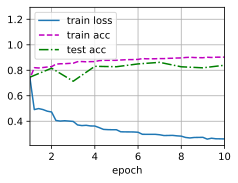

In [59]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 练习

1. 在使用批量规范化之前，我们是否可以从全连接层或卷积层中删除偏置参数？为什么？

2. 比较LeNet在使用和不使用批量规范化情况下的学习率。

    1. 绘制训练和测试准确度的提高。
    2. 学习率有多高？

3. 我们是否需要在每个层中进行批量规范化？尝试一下？

4. 可以通过批量规范化来替换暂退法吗？行为会如何改变？

5. 确定参数beta和gamma，并观察和分析结果。

6. 查看高级API中有关BatchNorm的在线文档，以查看其他批量规范化的应用。

7. 研究思路：可以应用的其他“规范化”转换？可以应用概率积分变换吗？全秩协方差估计可以么？

## 7.6 残差网络 ResNet

In [33]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [34]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_lxlconv=False, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=stride)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_lxlconv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=stride)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [35]:
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)

In [36]:
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [37]:
blk = Residual(3, 6, use_lxlconv=True, stride=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

### 7.6.3 ResNet模型

In [38]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [39]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_lxlconv=True, stride=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [40]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [41]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(),
                    nn.Linear(512, 10))

In [42]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape \t', X.shape)

Sequential output shape 	 torch.Size([1, 64, 56, 56])
Sequential output shape 	 torch.Size([1, 64, 56, 56])
Sequential output shape 	 torch.Size([1, 128, 28, 28])
Sequential output shape 	 torch.Size([1, 256, 14, 14])
Sequential output shape 	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape 	 torch.Size([1, 512, 1, 1])
Flatten output shape 	 torch.Size([1, 512])
Linear output shape 	 torch.Size([1, 10])


### 7.6.4 训练模型

loss 0.121, train acc 0.953, test acc 0.895
20536.0 examples/sec on cuda:0


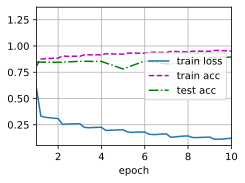

In [43]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

1. 图7.4.1中的Inception块与残差块之间的主要区别是什么？在删除了Inception块中的一些路径之后，它们是如何相互关联的？

2. 参考ResNet论文 (He et al., 2016)中的表1，以实现不同的变体。

3. 对于更深层次的网络，ResNet引入了“bottleneck”架构来降低模型复杂性。请试着去实现它。

4. 在ResNet的后续版本中，作者将“卷积层、批量规范化层和激活层”架构更改为“批量规范化层、激活层和卷积层”架构。请尝试做这个改进。详见 (He et al., 2016)中的图1。

5. 为什么即使函数类是嵌套的，我们仍然要限制增加函数的复杂性呢？

## 7.7 稠密连接网络

### 7.7.2 稠密块体

In [44]:
import torch
from torch import nn
from d2l import torch as d2l

In [45]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1)
    )

In [46]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels
            ))
        self.net = nn.Sequential(*layer)
    
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1)
        return X
        

In [47]:
blk = DenseBlock(2, 3, 10)
X = torch.rand(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

### 7.7.3 过渡层

In [48]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2)
    )

In [49]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

### 7.7.4 DenseNet模型

In [50]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, padding=2), nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [51]:
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    num_channels += num_convs * growth_rate
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [52]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10)
)

loss 0.163, train acc 0.941, test acc 0.854
1977.0 examples/sec on cuda:0


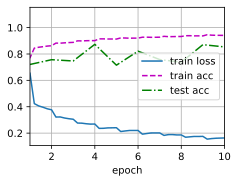

In [53]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

1. 为什么我们在过渡层使用平均汇聚层而不是最大汇聚层？

2. DenseNet的优点之一是其模型参数比ResNet小。为什么呢？

3. DenseNet一个诟病的问题是内存或显存消耗过多。

    1. 真的是这样吗？可以把输入形状换成224*224，来看看实际的显存消耗。
    2. 有另一种方法来减少显存消耗吗？需要改变框架么？

4. 实现DenseNet论文 (Huang et al., 2017)表1所示的不同DenseNet版本。

5. 应用DenseNet的思想设计一个基于多层感知机的模型。将其应用于 4.10节中的房价预测任务。